In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# # for dirname, _, filenames in os.walk('chest_xray/'):
# #     for filename in filenames:
# #         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

# Import Libraries

In [2]:
#!conda list

In [67]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2 
import sys
sys.path.append('../../src')
# CNN Class and methods
from model_utils import *
from data_functions import *

# Description of the Pneumonia Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,216 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.



# Load Dataset

In [40]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
                
            except Exception as e:
                print(e)
                
    return np.array(data)

In [56]:
TRAIN = get_training_data('../../data/chest_xray/train')
TEST = get_training_data('../../data/chest_xray/test')
VAL = get_training_data('../../data/chest_xray/val')

In [6]:
# print('Train: ', len(train))
# print('Train[0]: ', len(train[0]))
# print('Train[0][0]: ', len(train[0][0]))
# print('Train[0][0][0]: ', len(train[0][0][0]))

# print("\n\nType------>")
# print('Train: ', type(train))
# print('Train[0]: ', type(train[0]))
# print('Train[0][0]: ', type(train[0][0]))
# print('Train[0][0][0]: ', type(train[0][0][0]))

# print("\n\nShape")
# print('Train: ', train.shape)
# print('Train[0]: ', train[0].shape)
# print('Train[0][0]: ', train[0][0].shape)
# print('Train[0][0][0]: ', train[0][0][0].shape)


Train:  5216
Train[0]:  2
Train[0][0]:  150
Train[0][0][0]:  150


Type------>
Train:  <class 'numpy.ndarray'>
Train[0]:  <class 'numpy.ndarray'>
Train[0][0]:  <class 'numpy.ndarray'>
Train[0][0][0]:  <class 'numpy.ndarray'>


Shape
Train:  (5216, 2)
Train[0]:  (2,)
Train[0][0]:  (150, 150, 3)
Train[0][0][0]:  (150, 3)


# Data Visualization and Preprocessing

In [1]:
# l = []

# #iterate through train images
# for i in train:
#     if(i[1] == 0):
#         l.append("Pneumonia")
    
#     else:
#         l.append("Normal")

# sns.set_style('darkgrid')
# sns.countplot(x=l)

### The data seems imbalanced . To increase the no. of training examples, we will use data augmentation
### Previewing the images of both the classes

In [ ]:
# plot image data from first [1] train image ("Pneumonia" lungs)
plt.figure(figsize = (5,5))
plt.imshow(TRAIN[0][0], cmap='gray')
plt.title(labels[TRAIN[0][1]])
plt.axis('off')

# plot image data from last [-1] train image ("Normal" lungs)
plt.figure(figsize = (5,5))
plt.imshow(TRAIN[-1][0], cmap='gray')
plt.title(labels[TRAIN[-1][1]])
plt.axis('off')

(-0.5, 149.5, 149.5, -0.5)

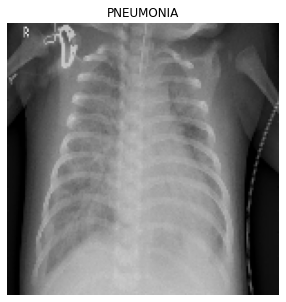

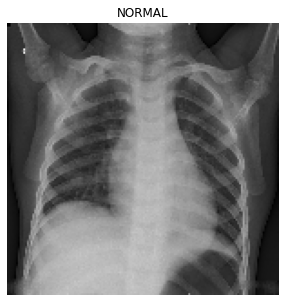

In [44]:
# plot image data from first [1] train image ("Pneumonia" lungs)
plt.figure(figsize = (5,5))
plt.imshow(TRAIN[0][0], cmap='gray')
plt.title(labels[TRAIN[0][1]])
plt.axis('off')

# plot image data from last [-1] train image ("Normal" lungs)
plt.figure(figsize = (5,5))
plt.imshow(TRAIN[-1][0], cmap='gray')
plt.title(labels[TRAIN[-1][1]])
plt.axis('off')

In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split


def get_img_paths(base_dir, ignore_filetypes=['.txt']):
    """
    Inputs:
        base_dir (string/ os.path type) relative path to the directory with folders containing images
        *kwargs
        ignore_filetypes (list of strings) filetypes to exclude from output
        type_foldes (dictionary) folders that identify different filetypes and add identifiers to add to output
    Returns:
        paths (list of tuples) relative paths to files with identifiers
    """
    normal_paths = []
    pneumonia_paths = []

    for root, dirs, files in os.walk(base_dir):
        # remove undesired files
        if ignore_filetypes:
            # check each file
            for file in files:
                for file_type in ignore_filetypes:
                    if file_type in file:
                        files.remove(file)
        if files:
            for file in files:
                full_path = os.path.join(root, file)

                if 'NORMAL' in full_path:
                    normal_paths.append((full_path, 0))

                elif 'PNEUMONIA' in full_path:
                    pneumonia_paths.append((full_path, 1))

    #         if type_folders:
    #             for key, value in type_folders.items():
    #                 if key in root:

    #         print('root: ', root)
    #         print('files: ', files[:5], len(files))
    #         print('paths: ', paths)
    normal_paths.extend(pneumonia_paths)
    return normal_paths


def custom_tts(data, train_val_test_percents=(0.8, 0.025, 0.175), random_state=2021):
    """
    This function takes a tuple of data and returns a tuple of train, test, and validation data
    Input:
        data (list/ array like) each entry contians a file path in position [0] and classification in position [1]
        train_val_test_percents (triple) triple containing decimal representations of split percentages used in train test split
        *kwargs

    Returns:
        x_train
        x_val
        x_test

    """
    # Extract percentages used in split from triple
    train_pct = train_val_test_percents[0]
    test_pct = 1 - train_pct
    val_pct = train_val_test_percents[0] / test_pct
    paths = [d[0] for d in data]
    types = [t[1] for t in data]
    x_train, x_test, y_train, y_test = train_test_split(paths, types, train_size=train_pct, random_state=random_state)

    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=train_pct, random_state=random_state)

    return x_train, x_val, x_test, y_train, y_val, y_test


def get_data(x, y, img_size=150):
    """
    This function takes an image type and classification with matching index and returns  image data with classification

    Input:
        x (list of path like entries) paths leading to image data to be loaded
        y (list of classification) list of classifications matching index of x data

    Returns:
        data (np.array) image data with classification
    """


    data = []

    for i in range(len(x)):
        path = x[i]
        class_num = y[i]

        #         for img in os.listdir(path):

        try:
            img_arr = cv2.imread(path)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
            data.append([resized_arr, class_num])

        except Exception as e:
            print(e)

    return np.array(data)

In [68]:
base_dir = '../../data/chest_xray'
paths = get_img_paths(base_dir)
len(paths)
x_train, x_val, x_test, y_train, y_val, y_test = custom_tts(paths, train_val_test_percents=(0.8, 0.025, 0.175))
x_train = get_data(x_train, y_train)
x_test = get_data(x_test, y_test)
x_val = get_data(x_val, y_val)

In [78]:
pneumonia_train_indicies = []
normal_train_indicies = []

for i in range(len(x_train)):
    
    if y_train[i] == 1:
        pneumonia_train_indicies.append(i)
        
    else:
        normal_train_indicies.append(i)

(-0.5, 149.5, 149.5, -0.5)

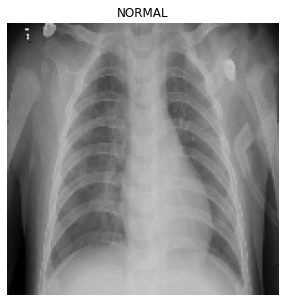

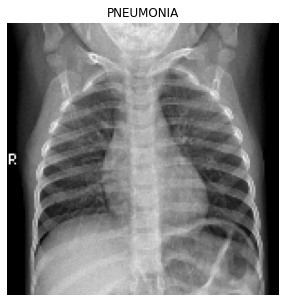

In [83]:
# plot image data from first [1] train image ("Pneumonia" lungs)
plt.figure(figsize = (5,5))
plt.imshow(x_train[pneumonia_train_indicies[5]][0], cmap='gray')
plt.title(labels[x_train[pneumonia_train_indicies[5]][1]])
plt.axis('off')

# plot image data from last [-1] train image ("Normal" lungs)
plt.figure(figsize = (5,5))
plt.imshow(x_train[normal_train_indicies[5]][0], cmap='gray')
plt.title(labels[x_train[normal_train_indicies[5]][1]])
plt.axis('off')

In [46]:
# # lists will contain image data with labels (normal or pneumonia)
# x_train = []
# y_train = []

# x_val = []
# y_val = []

# x_test = []
# y_test = []

# for feature, label in train:
#     x_train.append(feature)
#     y_train.append(label)
    
# for feature, label in val:
#     x_val.append(feature)
#     y_val.append(label)
    
# for feature, label in test:
#     x_test.append(feature)
#     y_test.append(label)

In [47]:
train[0]

array([array([[[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [ 40,  40,  40],
        [ 39,  39,  39],
        [ 21,  21,  21]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [ 37,  37,  37],
        [ 43,  43,  43],
        [ 19,  19,  19]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [ 43,  43,  43],
        [253, 253, 253],
        [ 16,  16,  16]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [250, 250, 250],
        [145, 145, 145],
        [  1,   1,   1]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  7,   7,   7],
        [ 11,  11,  11],
        [  2,   2,   2]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  2,   2,   2],
        [  1,   1,   1],
        [  2,   2

In [ ]:
for i in range(len(x_train)):
    

(-0.5, 149.5, 149.5, -0.5)

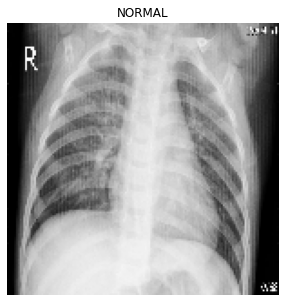

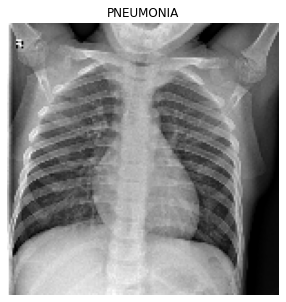

In [54]:
# plot image data from first [1] train image ("Pneumonia" lungs)
plt.figure(figsize = (5,5))
plt.imshow(x_train[0][0], cmap='gray')
plt.title(labels[x_train[0][1]])
plt.axis('off')

# plot image data from last [-1] train image ("Normal" lungs)
plt.figure(figsize = (5,5))
plt.imshow(x_train[-1][0], cmap='gray')
plt.title(labels[x_train[-1][1]])
plt.axis('off')

(-0.5, 149.5, 149.5, -0.5)

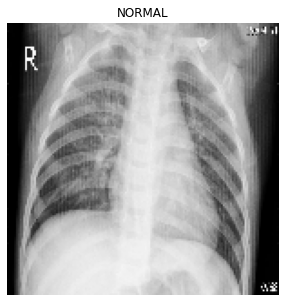

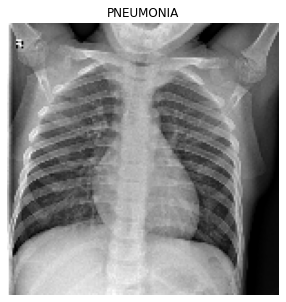

In [50]:
# plot image data from first [1] train image ("Pneumonia" lungs)
plt.figure(figsize = (5,5))
plt.imshow(x_train[0][0], cmap='gray')
plt.title(labels[x_train[0][1]])
plt.axis('off')

# plot image data from last [-1] train image ("Normal" lungs)
plt.figure(figsize = (5,5))
plt.imshow(x_train[-1][0], cmap='gray')
plt.title(labels[x_train[-1][1]])
plt.axis('off')

# We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0:1] data than on [0:255].

In [49]:
img_size=150

In [32]:
# normalize data
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [35]:
x_train[0][0]

array([[[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.15686275, 0.15686275, 0.15686275],
        [0.15294118, 0.15294118, 0.15294118],
        [0.08235294, 0.08235294, 0.08235294]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.14509804, 0.14509804, 0.14509804],
        [0.16862745, 0.16862745, 0.16862745],
        [0.0745098 , 0.0745098 , 0.0745098 ]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.16862745, 0.16862745, 0.16862745],
        [0.99215686, 0.99215686, 0.99215686],
        [0.0627451 , 0.0627451 , 0.0627451 ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [33]:
# resize data for sequential model
# img_size from Load Dataset cell, cell 4
# img_size = 150
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

ValueError: cannot reshape array of size 9368 into shape (150,150,3)

# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# datagen is the SMOTE of img classifiers
# use datagen to handle class imbalance and prevent overfitting

datagen = ImageDataGenerator(\
                            featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False, 
                            rotation_range=30, 
                            zoom_range=0.2,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

In [ ]:
# # With data augmentation to prevent overfitting and handling the imbalance in dataset

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.2, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip = True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


# datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 30 degrees
Randomly Zoom by 20% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

# FSM

In [ ]:
# # instantial Sequential deep learning model and add layers
# model = Sequential() 
# model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(150,150,3)))
# model.add(Flatten())
# model.add(Dense(units=1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])
# model.summary()

# PTann Model

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=10**-9)

In [ ]:
model_2= Sequential()
model_2.add(Conv2D(32, (3,3), strides =1, padding = 'same', activation ='relu', input_shape = (150,150,3)))

model_2.add(MaxPool2D((2,2), strides=2, padding='same'))
model_2.add(Conv2D(64, (3,3), strides =1, padding ='same', activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(MaxPool2D((2,2), strides=2, padding='same'))
model_2.add(MaxPool2D((2,2), strides=2, padding='same'))
model_2.add(Conv2D(64, (3,3), strides =1, padding ='same', activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(units=128, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['Recall'])
model_2.summary()

# Run Model

In [18]:
# history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data=datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction])

In [19]:
history = model_2.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data=datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/12
147/147 [==============================] - 134s 915ms/step - loss: 0.6043 - recall: 0.9953 - val_loss: 0.6251 - val_recall: 1.0000
Epoch 2/12
147/147 [==============================] - 137s 929ms/step - loss: 0.5897 - recall: 1.0000 - val_loss: 0.5807 - val_recall: 1.0000
Epoch 3/12
147/147 [==============================] - 129s 878ms/step - loss: 0.5899 - recall: 1.0000 - val_loss: 0.5815 - val_recall: 1.0000
Epoch 4/12
147/147 [==============================] - 120s 814ms/step - loss: 0.5889 - recall: 1.0000 - val_loss: 0.5867 - val_recall: 1.0000
Epoch 5/12
147/147 [==============================] - 124s 843ms/step - loss: 0.5891 - recall: 1.0000 - val_loss: 0.5813 - val_recall: 1.0000
Epoch 6/12
147/147 [==============================] - 129s 880ms/step - loss: 0.5882 - recall: 1.0000 - val_loss: 0.5798 - val_recall: 1.0000
Epoch 7/12
147/147 [==============================] - 137s 929ms/step - loss: 0.5891 - recall: 1.0000 - val_loss: 0.5798 - val_recall: 1.0000
Epoch 

In [20]:
print("Model Loss: ", model_2.evaluate(x_test, y_test)[0])
print("Model Accuracy: ", model_2.evaluate(x_test, y_test)[1])

8/8 [==============================] - ETA: 0s - loss: 0.6341 - recall: 1.00 - ETA: 0s - loss: 0.5446 - recall: 1.00 - ETA: 0s - loss: 0.5387 - recall: 1.00 - ETA: 0s - loss: 0.5715 - recall: 1.00 - ETA: 0s - loss: 0.5697 - recall: 1.00 - ETA: 0s - loss: 0.5625 - recall: 1.00 - ETA: 0s - loss: 0.5728 - recall: 1.00 - ETA: 0s - loss: 0.5797 - recall: 1.00 - 1s 114ms/step - loss: 0.5797 - recall: 1.0000
Model Loss:  0.5796709656715393
8/8 [==============================] - ETA: 0s - loss: 0.6341 - recall: 1.00 - ETA: 0s - loss: 0.5446 - recall: 1.00 - ETA: 0s - loss: 0.5387 - recall: 1.00 - ETA: 0s - loss: 0.5715 - recall: 1.00 - ETA: 0s - loss: 0.5697 - recall: 1.00 - ETA: 0s - loss: 0.5625 - recall: 1.00 - ETA: 0s - loss: 0.5728 - recall: 1.00 - ETA: 0s - loss: 0.5797 - recall: 1.00 - 1s 112ms/step - loss: 0.5797 - recall: 1.0000
Model Accuracy:  1.0


In [20]:
# history.history

In [23]:
print("Model Loss: ", model.evaluate(x_test, y_test)[0])
print("Model Accuracy: ", model.evaluate(x_test, y_test)[1])

20/20 [==============================] - ETA: 0s - loss: 0.0266 - recall: 0.0000e+ - ETA: 0s - loss: 0.0444 - recall: 0.0000e+ - ETA: 0s - loss: 0.0533 - recall: 0.0000e+ - ETA: 0s - loss: 0.0817 - recall: 0.0000e+ - ETA: 0s - loss: 0.0948 - recall: 0.0000e+ - ETA: 0s - loss: 0.0921 - recall: 0.0000e+ - ETA: 0s - loss: 0.1051 - recall: 0.0000e+ - ETA: 0s - loss: 0.1052 - recall: 0.0000e+ - ETA: 0s - loss: 0.1033 - recall: 0.0000e+ - ETA: 0s - loss: 0.0975 - recall: 0.0000e+ - ETA: 0s - loss: 0.1023 - recall: 0.0000e+ - ETA: 0s - loss: 0.1653 - recall: 0.4231   - ETA: 0s - loss: 0.2373 - recall: 0.37 - ETA: 0s - loss: 0.2643 - recall: 0.51 - ETA: 0s - loss: 0.2956 - recall: 0.55 - ETA: 0s - loss: 0.4319 - recall: 0.50 - ETA: 0s - loss: 0.4412 - recall: 0.52 - ETA: 0s - loss: 0.4437 - recall: 0.56 - 1s 54ms/step - loss: 0.4456 - recall: 0.5684
Model Loss:  0.4456031024456024
20/20 [==============================] - ETA: 0s - loss: 0.0266 - recall: 0.0000e+ - ETA: 0s - loss: 0.0444 - reca

In [22]:
# plot_result = [i for i in range(12)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['recall']
# train_loss = history.history['loss']
# val_acc = history.history['val_recall']
# val_loss = history.history['val_loss']
# fig.set_size_inches(20,10)

# ax[0].plot(plot_result , train_acc , 'go-' , label = 'Loss')
# ax[0].plot(plot_result , val_acc , 'ro-' , label = 'Validation Accuracy')
# ax[0].set_title('Training & Validation Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Recall")

# ax[1].plot(plot_result , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(plot_result , val_loss , 'r-o' , label = 'Validation Loss')
# ax[1].set_title('Testing Accuracy & Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Training & Validation Loss")
# plt.show()

In [24]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:100]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [62]:
predictions2 = model_2.predict_classes(x_test)
predictions2 = predictions2.reshape(1,-1)[0]
predictions2[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [85]:
cm2 = confusion_matrix(y_test,predictions2)
cm2

array([[375,  15],
       [ 42, 192]], dtype=int64)

In [86]:
cm2 = pd.DataFrame(cm2, index=['0', '1'], columns=['0','1'])

<AxesSubplot:>

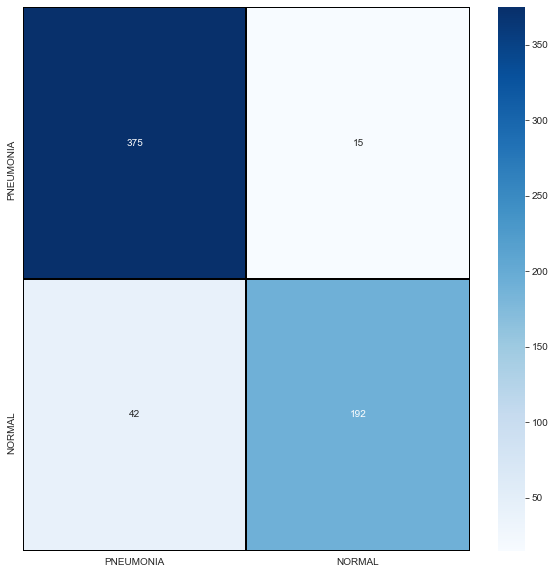

In [87]:
plt.figure(figsize=(10,10))
sns.heatmap(cm2, cmap='Blues', linecolor='black', lw=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)

In [25]:
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.79      0.97      0.87       390
   Normal (Class 1)       0.92      0.57      0.70       234

           accuracy                           0.82       624
          macro avg       0.85      0.77      0.79       624
       weighted avg       0.84      0.82      0.81       624



In [26]:
cm = confusion_matrix(y_test,predictions)
cm

array([[378,  12],
       [101, 133]], dtype=int64)

In [27]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0','1'])

<AxesSubplot:>

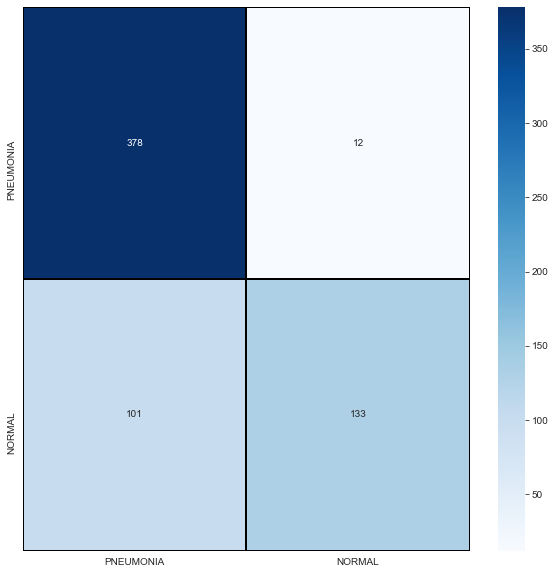

In [28]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap='Blues', linecolor='black', lw=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)

# Implement LIME to understand model

In [21]:
# generate segementation for image
# import package for segmentation
import skimage.segmentation
from skimage.segmentation import mark_boundaries


In [22]:
from skimage.color import rgb2gray

(-0.5, 149.5, 149.5, -0.5)

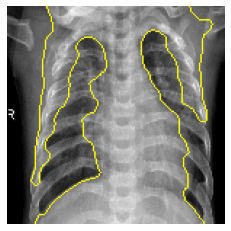

In [31]:

# instantiate superpixels for purtubations
# skimage.segmentation.quickshift(x_train[0])
# superpxls = skimage.segmentation.active_contour(x_train[0], init) #in this case, init is the spline which encloses the boundary of interest
# reshape images for use in grayscale skimage.segmentation
pne_pos = rgb2gray(x_train[2]).reshape(150,150)
pne_neg = rgb2gray(x_train[0]).reshape(150,150)

# create boundary with chan_ves
chan_ves_boundary = skimage.segmentation.chan_vese(pne_pos)
plt.imshow(mark_boundaries(pne_pos, chan_ves_boundary))
plt.axis('off')

In [32]:
# # create boundarywith find_boundary
# fb_boundary = skimage.segmentation.find_boundaries(pne_pos)
# plt.imshow(mark_boundaries(pne_pos, fb_boundary))
# plt.axis('off')

(-0.5, 149.5, 149.5, -0.5)

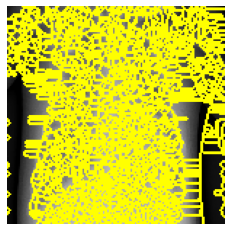

In [33]:
# create boundary with watershed
watershed_boundary = skimage.segmentation.watershed(pne_neg)
plt.imshow(mark_boundaries(pne_neg, watershed_boundary))
plt.axis('off')

In [34]:
# # combine find_boundary with watershed boundaries
# ws_fb_boundary = skimage.segmentation.find_boundaries(watershed_boundary)
# plt.imshow(mark_boundaries(pne_pos, ws_fb_boundary))
# plt.axis('off')

In [35]:
# # combine find_boundary with chan_ves boundary
# cv_fb_boundary = skimage.segmentation.find_boundaries(chan_ves_boundary)
# plt.imshow(mark_boundaries(pne_pos, cv_fb_boundary))
# plt.axis('off')

In [36]:
# plt.imshow(x_train[2], cmap='gray')
# plt.axis('off')

In [37]:
## Example from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py
# import matplotlib.pyplot as plt
# import numpy as np

# from skimage.data import astronaut
# from skimage.color import rgb2gray
# from skimage.filters import sobel
# from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
# from skimage.segmentation import mark_boundaries
# from skimage.util import img_as_float

# img = img_as_float(astronaut()[::2, ::2])

# segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
# segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
#                      start_label=1)
# segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)

# gradient = sobel(rgb2gray(img))
# segments_watershed = watershed(gradient, markers=250, compactness=0.001)

# print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
# print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
# print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

# fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

# ax[0, 0].imshow(mark_boundaries(img, segments_fz))
# ax[0, 0].set_title("Felzenszwalbs's method")
# ax[0, 1].imshow(mark_boundaries(img, segments_slic))
# ax[0, 1].set_title('SLIC')
# ax[1, 0].imshow(mark_boundaries(img, segments_quick))
# ax[1, 0].set_title('Quickshift')
# ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
# ax[1, 1].set_title('Compact watershed')

# for a in ax.ravel():
#     a.set_axis_off()

# plt.tight_layout()
# plt.show()

In [38]:
# skimage.segmentation.mark_boundaries(pne_pos/2+0.5, superpixels)

In [39]:
import skimage.io

In [40]:
len(x_train)

5216

In [41]:

from skimage.color import gray2rgb

(-0.5, 149.5, 149.5, -0.5)

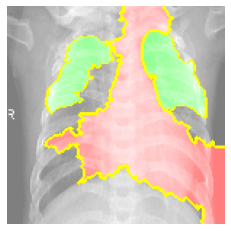

In [43]:
# index for a pneumonatic image
pne_ind = 2

# index for a healthy lung
hlth_ind = 0

# instantiate image explainer
explainer = li.LimeImageExplainer()

image = x_train[pne_ind]
explanation = explainer.explain_instance(image, model.predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')

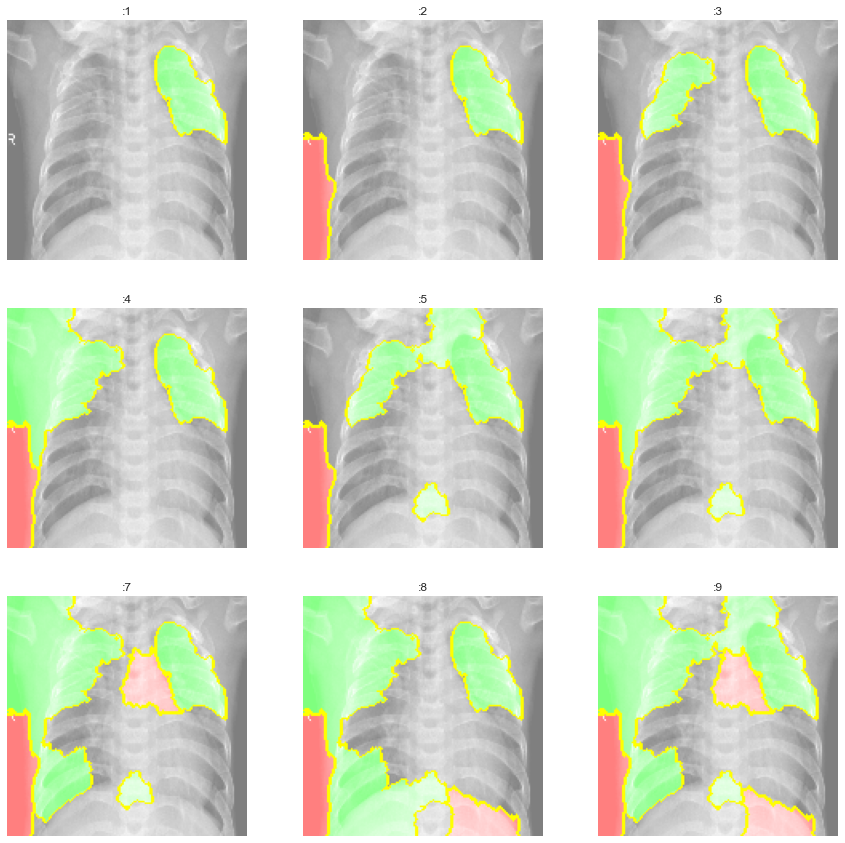

In [109]:
# instantiate image explainer
explainer = li.LimeImageExplainer()

image = x_train[pne_ind]

# iterate through several top labels and features
fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(1,10):
    m = (i-1) // 3
    n = (i-1) % 3
    
    explanation = explainer.explain_instance(image, model_2.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
    ax[m,n].imshow(mark_boundaries(temp/2 + 0.5, mask))
    ax[m,n].axis('off')
    ax[m,n].set_title(f':{i}')
plt.savefig('PneumoniaLIME')

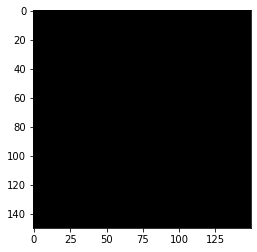

In [29]:
plt.imshow(x_train[10])

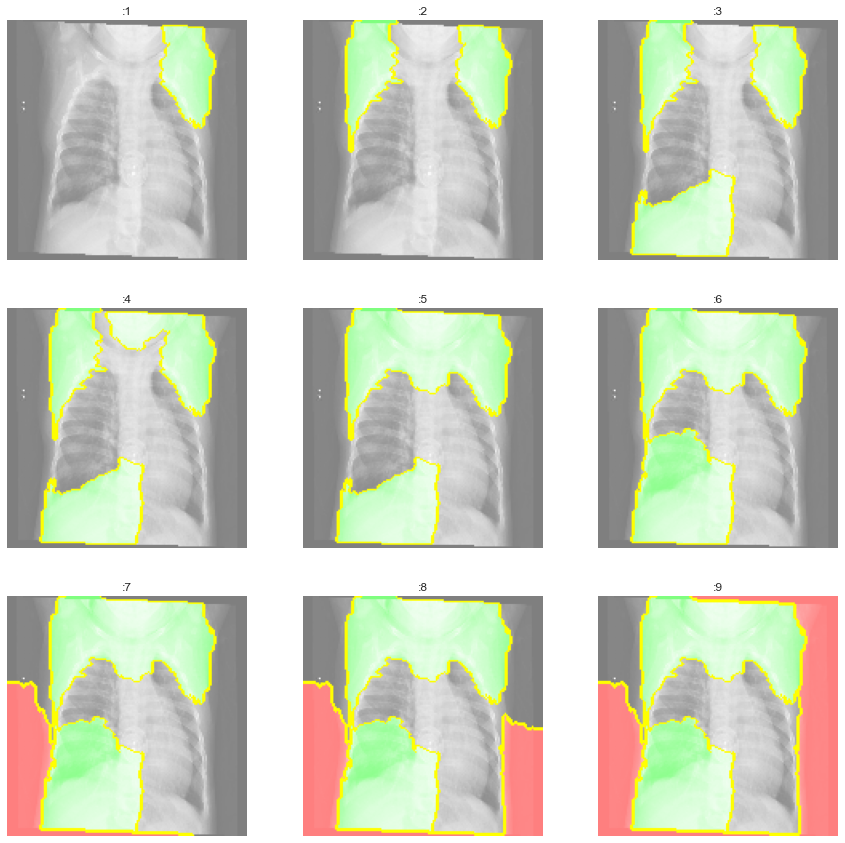

In [78]:
# instantiate image explainer
explainer = li.LimeImageExplainer()

image = x_train[10]

# iterate through several top labels and features
fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(1,10):
    m = (i-1) // 3
    n = (i-1) % 3
    
    explanation = explainer.explain_instance(image, model_2.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
    ax[m,n].imshow(mark_boundaries(temp/2 + 0.5, mask))
    ax[m,n].axis('off')
    ax[m,n].set_title(f':{i}')


In [110]:
y_train[10]

0

# Using Other Visualization Methods

In [ ]:
import keras.preprocessing.image as kpimg

In [98]:
len(x_val)

16

In [99]:
len(x_test)

624

In [49]:
model = None

In [ ]:
x_train[2].shape

In [ ]:
my_x = 

In [ ]:
# convert image of lungs with pneumonia to tensor
positive_img_tensor = kpimg.img_to_array(x_train[2])
positive_img_tensor = np.expand_dims(positive_img_tensor, axis=0)

print(positive_img_tensor.shape, pne_pos.shape)

In [ ]:
sys.getsizeof(positive_img_tensor)

In [ ]:
# activation function visualization from CNN appendix
import math 

# example image
ex_img = x_train[2].reshape(1, 150, 150, 3)
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = model

activations = activation_model.predict(ex_img)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)
print(total_features)

iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
        print(type(row), type(column))
        ax = axes[row, column]
        print(f'ax[{row}, {column}]')

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

In [86]:
import math 
import lime.lime_image as li

In [87]:
def lime_image(model, image, rows=3, columns=3, figsize=(15,15), min_superpixels=1, max_superpixels=10, positive_only=False, negative_only=False, 
               hide_rest=False, axis_off='off', subplot_titles=None, main_title='Different Features Analyzed by Model', save_fig=True):
    '''
    This function uses LimeImageExplainer from lime.lime_image to create a visual of the inner workings
        of the image processing neural network.
    It does this by separating the image into various regions known as "superpixels" and judging performance
        with and without these superpixels on the image.
    
    Inputs: model (keras sequantial model)
            image (array, tensor) iamge to be analyzed
            *kwargs
    
    Returns: subplots of image with masks of superpixels 
    '''
    
    # instantiate image explainer
    explainer = li.LimeImageExplainer()
    
    # instantiate plot to populate with explained images
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    
    # loop through number of superpixels to be included
    for i in range(min_superpixels, max_superpixels):
        
        # create index for subplots
        m = (i-min_superpixels) // 3
        n = (i-min_superpixels) % 3
        
        # explain prediciton with lime
        explanation = explainer.explain_instance(image, model.predict, top_labels=5, hide_color=0, num_samples=1000)
        temp, mask = explanation.get_image_and_mask(0, num_features=i, positive_only=positive_only, negative_only=negative_only, hide_rest=hide_rest)
        
        # plot results
        ax[m,n].imshow(mark_boundaries(temp/2 + 0.5, mask))
        ax[m,n].axis(axis_off)
        if not subplot_titles:
            ax[m,n].set_title(f'# of Superpixels: {i}')            
        
        else:
            ax[m,n].set_title(subplot_titles)
    fig.suptitle(main_title)
    
    if save_fig:
        plt.savefig('../../')


ValueError: Can not convert from object to float64.

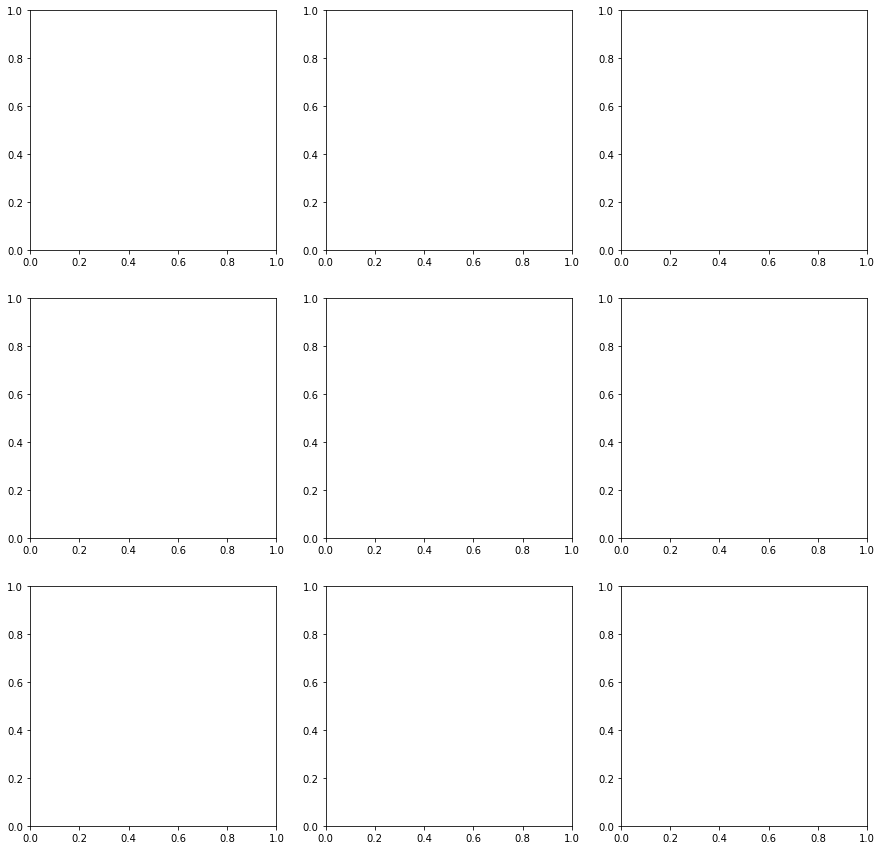

In [85]:
lime_image(model_2, x_train[10], min_superpixels=0, max_superpixels=9)

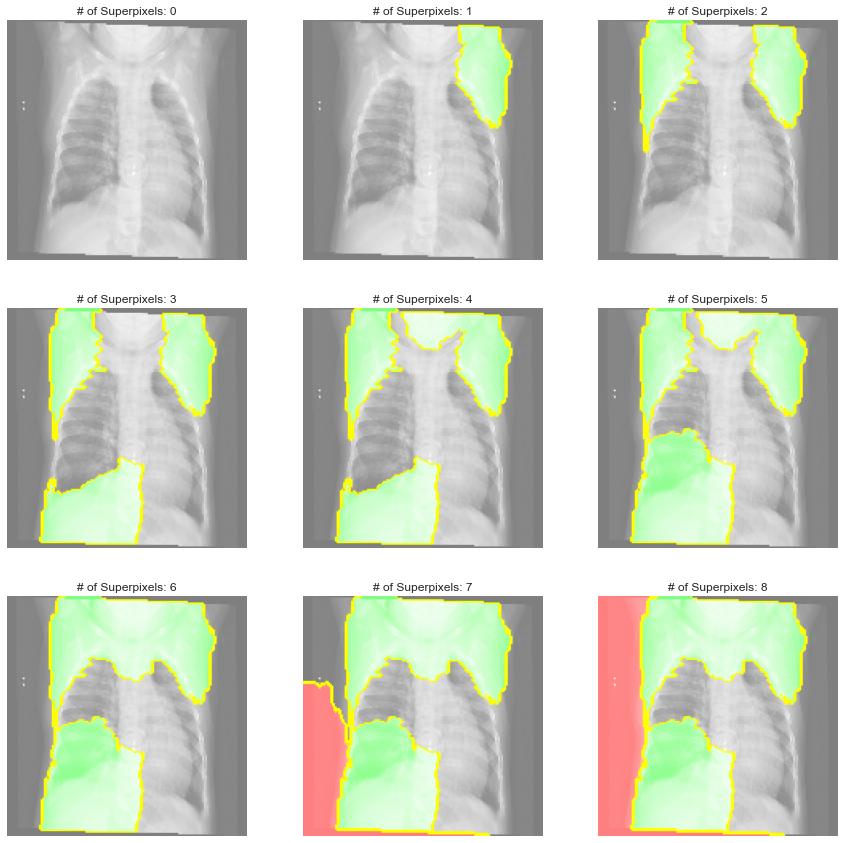

In [106]:
# instantiate image explainer
explainer = li.LimeImageExplainer()

image = x_train[10]

# iterate through several top labels and features
fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(0,9):
    m = (i) // 3
    n = (i) % 3
    
    explanation = explainer.explain_instance(image, model_2.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
    ax[m,n].imshow(mark_boundaries(temp/2 + 0.5, mask))
    ax[m,n].axis('off')
    ax[m,n].set_title(f'# of Superpixels: {i}')

In [83]:
predicted = model.predict(x_train)

In [84]:
predicted

array([[0.00210696],
       [0.12772715],
       [0.7173857 ],
       ...,
       [0.12095562],
       [0.92655206],
       [0.07614443]], dtype=float32)

In [88]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [89]:
predictions2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [90]:
good_preds = []
type_1 = []
type_2 = []

for i in range(len(y_test)):
    
    if y_test[i] == predictions[i]:
        good_preds.append(i)
    
    elif y_test[i] == 1:
        type_1.append(i)
        
    else:
        type_2.append(i)

NameError: name 'predictions' is not defined

In [93]:
type_2

[48, 53, 54, 83, 123, 154, 156, 157, 171, 180, 237, 245, 262, 296, 365]

In [84]:
type_1

NameError: name 'type_1' is not defined

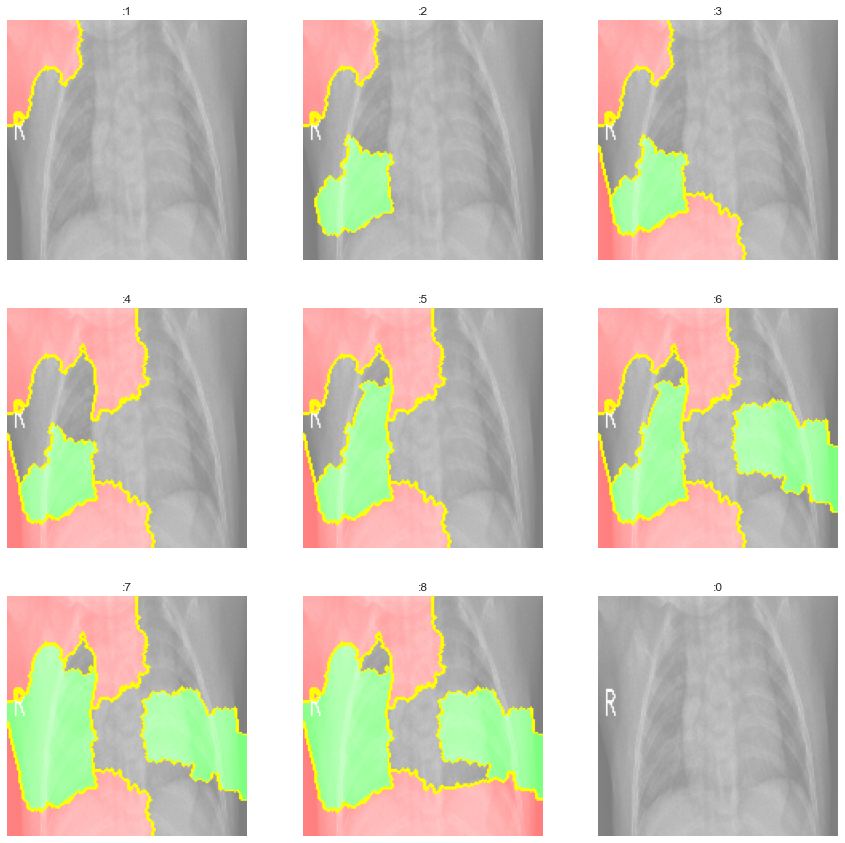

In [95]:
# instantiate image explainer
explainer = li.LimeImageExplainer()

image = x_test[type_1[0]]

# iterate through several top labels and features
fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(0,9):
    m = (i) // 3
    n = (i) % 3
    
    explanation = explainer.explain_instance(image, model_2.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
    ax[m,n].imshow(mark_boundaries(temp/2 + 0.5, mask))
    ax[m,n].axis('off')
    ax[m,n].set_title(f'# of Features:{i}')

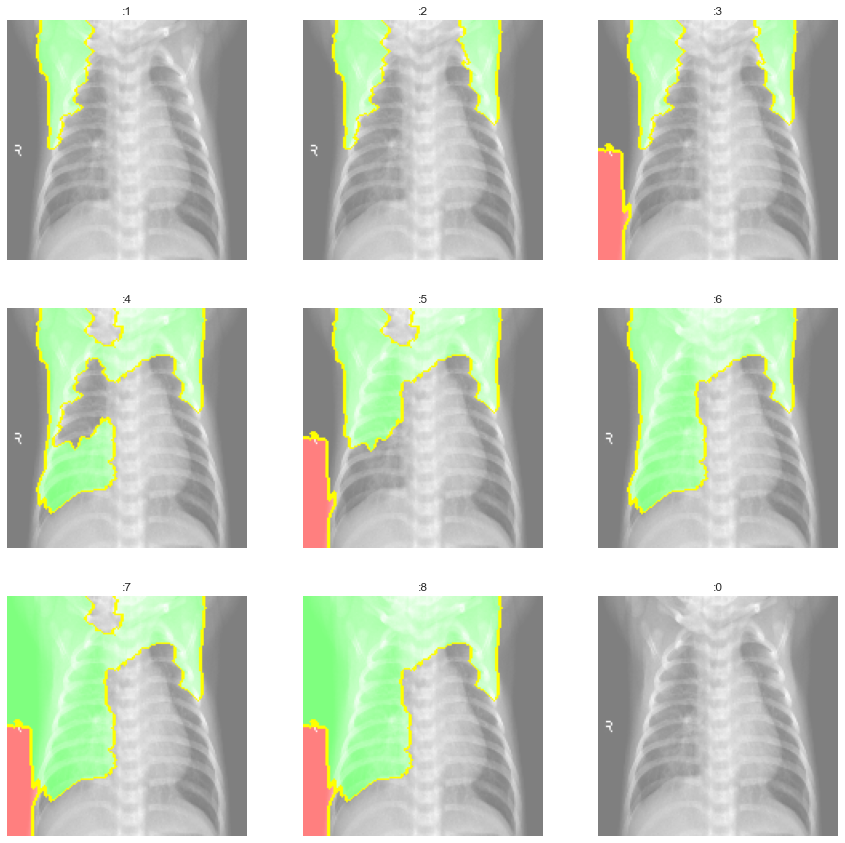

In [96]:
# instantiate image explainer
explainer = li.LimeImageExplainer()

image = x_test[type_2[0]]

# iterate through several top labels and features
fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(0,9):
    m = (i) // 3
    n = (i) % 3
    
    explanation = explainer.explain_instance(image, model_2.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
    ax[m,n].imshow(mark_boundaries(temp/2 + 0.5, mask))
    ax[m,n].axis('off')
    ax[m,n].set_title(f'# of Features:{i}')

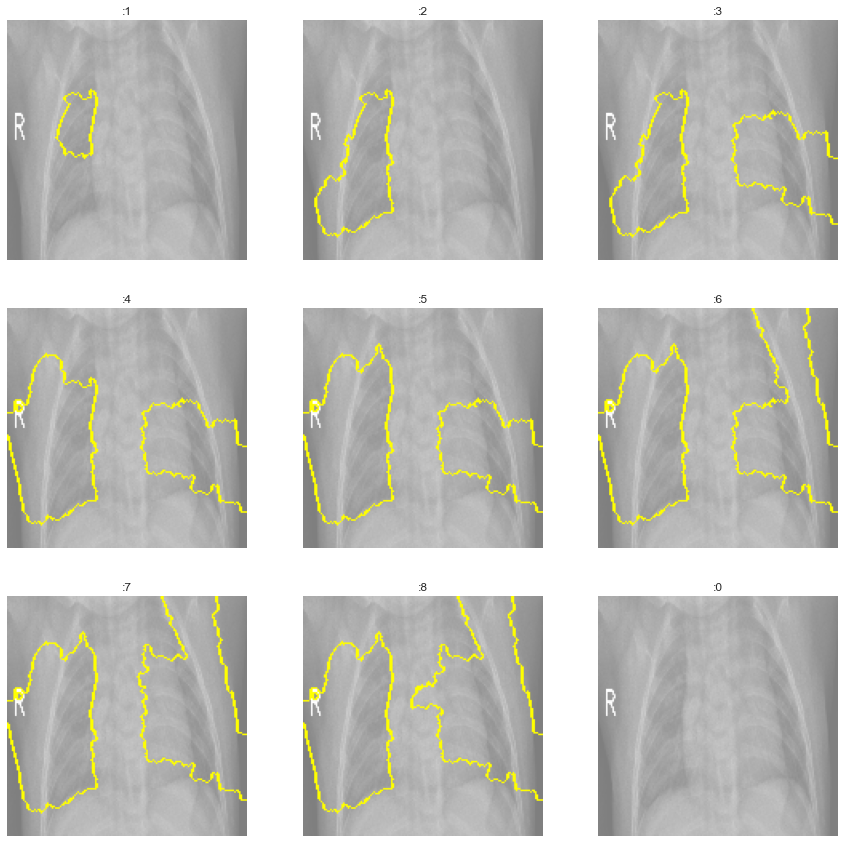

In [97]:
# instantiate image explainer
explainer = li.LimeImageExplainer()

image = x_test[type_1[0]]

# iterate through several top labels and features
fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(0,9):
    m = (i) // 3
    n = (i) % 3
    
    explanation = explainer.explain_instance(image, model_2.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=i, hide_rest=False)
    ax[m,n].imshow(mark_boundaries(temp/2 + 0.5, mask))
    ax[m,n].axis('off')
    ax[m,n].set_title(f'# of Features:{i}')